# Семинар по методам интеллектуального анализа данных
## Введение в сверточные нейронные сети и библиотеку Tensorflow 2.0

Содержание
- Задача классификации изображений
- Линейный классификатор
- Функция потерь, обучение линейного классификатора
- Сверточный слой нейросети
- Задачи, решаемые сверточными нейросетями

Отличный курс по нейросетям (видео лекций и материалы по курсу):

http://cs231n.stanford.edu/ CS231n: Convolutional Neural Networks for Visual Recognition (Stanford)

### Библиотека Tensorflow

<img align=left src="img/tf_logo.png">

https://www.tensorflow.org/

Другие библиотеки для обучения нейросетей:
- PyTorch https://pytorch.org/
- Apache MXNet https://mxnet.apache.org/
- Caffe2 https://caffe2.ai/

In [1]:
%matplotlib inline
import sys
import math
import tensorflow as tf
import pickle
import numpy as np
import sklearn
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)
print('Numpy version:', np.__version__)
print('Scikit-learn version:', sklearn.__version__)
print('Matplotlib version', matplotlib.__version__)

Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Tensorflow version: 2.0.0-alpha0
Numpy version: 1.16.2
Scikit-learn version: 0.20.3
Matplotlib version 3.0.3


In [2]:
# PATHS
PATH_CIFAR = Path('data') / 'cifar-10-batches-py'

### Задача классификации изображений

Пусть имеется набор изображений с известными метками классов (кошка, собака, машина и т.п.). Необходимо составить алгоритм, который будет определять метку класса для нового изображения. Наиболее известным набором размеченных изображений, на котором сравнивается качество разных алгоримов, является ImageNet, содержащий более 14 миллионов картинок, разделенных на 20000 классов.

Примеры изображений ImageNet:

![Imagenet_sample1](img/imagenet_sample1.jpg)
![Imagenet_sample1](img/imagenet_sample2.jpg)

Ежегодно проводится соревнование ImageNet Large Scale Visual Recognition Challenge (ILSVRC), где используется малая часть ImageNet (1.4 млн изображений, 1000 классов). В настоящее время нейросети показывают наилучшие результаты при решении этой задачи.

![Imagenet_winner_history](img/ILSVRC_winners.png)

- Deng et al, ImageNet: A Large-Scale Hierarchical Image Database, 2009.

Сети для классификации изображений ImageNet тренируются несколько дней. Чтобы уменьшить объем вычислений, мы будем использовать набор данных поменьше - **CIFAR**, который включает 10 классов, 50000 тренировочных и 10000 тестовых изображений.

CIFAR-10 можно загрузить по ссылке: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz и необходимо распаковать в папку data.

Изображения из набора данных CIFAR-10:

![CIRAR](img/cifar_classes.png)

In [3]:
def get_cifar10():
    CIFAR_DIM = (3, 32, 32)
    path_meta = PATH_CIFAR / 'batches.meta'
    paths_batches = [
        PATH_CIFAR / 'data_batch_1',
        PATH_CIFAR / 'data_batch_2',
        PATH_CIFAR / 'data_batch_3',
        PATH_CIFAR / 'data_batch_4',
        PATH_CIFAR / 'data_batch_5',    
    ]
    path_test = PATH_CIFAR / 'test_batch'
    
    # Train
    cifar10_train = {'data': [], 'labels': []}
    for path in paths_batches:
        with open(path, 'rb') as file:
            x = pickle.load(file, encoding='bytes')
            cifar10_train['data'].append(x[b'data'])
            cifar10_train['labels'].append(x[b'labels'])
    cifar10_train['data'] = np.concatenate(cifar10_train['data'])
    cifar10_train['data'] = cifar10_train['data'].reshape(-1, *CIFAR_DIM).transpose(0, 2, 3, 1)
    cifar10_train['labels'] = np.concatenate(cifar10_train['labels'])
    
    # Test
    cifar10_test = {}
    with open(path_test, 'rb') as file:
        x = pickle.load(file, encoding='bytes')
        cifar10_test['data'] = x[b'data'].reshape(-1, *CIFAR_DIM).transpose(0, 2, 3, 1)
        cifar10_test['labels'] = np.array(x[b'labels'], dtype=np.int32)
    
    # Class names
    with open(path_meta, 'rb') as file:
        class_names = [bytes_name.decode() for bytes_name 
                       in pickle.load(file, encoding='bytes')[b'label_names']]
    
    return cifar10_train, cifar10_test, class_names

In [4]:
# Загрузим датасет CIFAR10
cifar10_train, cifar10_test, class_names = get_cifar10()

cifar10_train_size = cifar10_train['data'].shape[0]
cifar10_test_size = cifar10_test['data'].shape[0]

# Нам также понадобяться изображения в виде вектора пикселей
# длиной 3072 = 32x32x3
cifar10_train_vectors = cifar10_train['data'].reshape(cifar10_train_size, -1)
cifar10_test_vectors = cifar10_test['data'].reshape(cifar10_test_size, -1)

print('Имена классов:', class_names)
print('Размер тренировочных данных:', cifar10_train_size)
assert cifar10_train_size == cifar10_train['labels'].size
print('Размер тестовых данных:', cifar10_test_size)
assert cifar10_test_size == cifar10_test['labels'].size
print('Размер изображения: {} (32x32x3)'.format(cifar10_train['data'].shape[1]))
print('Количество пикселей на изображении: {}'.format(np.product(cifar10_train['data'].shape[1:])))

Имена классов: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Размер тренировочных данных: 50000
Размер тестовых данных: 10000
Размер изображения: 32 (32x32x3)
Количество пикселей на изображении: 3072


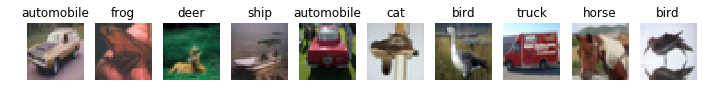

In [5]:
# Построим 10 случайных изображений CIFAR
def plot_cifar_imgs(imgs, labels, interpolation=None):
    plt.figure(figsize=(len(imgs) + 2, 3))
    for img_num, (img, lbl) in enumerate(zip(imgs, labels), 1):
        plt.subplot(1, len(imgs), img_num)
        plt.imshow(img, interpolation=interpolation)
        plt.title(class_names[lbl])
        plt.axis('off')

show_idxs = np.random.randint(0, cifar10_train_size, size=10)
images = [cifar10_train['data'][idx] for idx in show_idxs]
labels = [cifar10_train['labels'][idx] for idx in show_idxs]
plot_cifar_imgs(images, labels)

In [6]:
# Посмотрим на распредление классов
print(np.unique(cifar10_train['labels'], return_counts=True)[1])
print(np.unique(cifar10_test['labels'], return_counts=True)[1])

[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Видно, что изображения CIFAR10 распределены по классам равномерно.

### Обучение однослойной нейросети
В основе нейросети лежит линейная функция (простейший классификатор):

$$y = Wx + b,$$

где $x$ - входной вектор $\mathbb{R}^N$, $y$ - выходной вектор  $\mathbb{R}^M$, $W$ - матрица весов $\mathbb{R}^{M \times N}$, $b$ - вектор смещений $\mathbb{R}^M$.

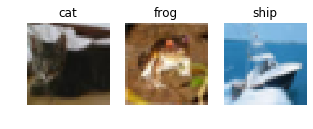

In [7]:
# Возмем 3 изображения разных классов
labels = [3, 6, 8]
images = np.stack([cifar10_train['data'][np.where(cifar10_train['labels'] == lbl)[0][0]] for lbl in labels])
plot_cifar_imgs(images, labels)

In [8]:
# Представим изображения в виде векторов длинной 3072 = 32x32x3
images = images.reshape(3, -1)

In [9]:
# Создадим случайную матрицу весов и вектор смещений
n = images[0].shape[0]
m = 10  # 10 классов
weights = tf.random.normal((m, n)) / 10
bias = tf.random.normal((m, ))

In [10]:
# Применим линейную функцию к изображениям
# images - numpy массив, weights - tensorflow массив, но их можно перемножать
y = images @ tf.transpose(weights) + bias  # @ - умножение матриц (== tf.matmul)
print(y)  # получается tensorflow массив

tf.Tensor(
[[  628.1846     469.71124   -311.75424   -599.56866   1051.7388
    415.46646   -584.81775   -469.52762    188.28607   -407.80777 ]
 [ -295.22308    -34.645424  -576.3702    -613.0585    1091.5469
    113.88597   -251.83186   -371.55908   -306.05368    -30.687168]
 [  563.644      169.40326  -1368.1985    -580.75696   1981.9872
    105.22322   -394.27127  -1232.8837    -924.8567    -735.95557 ]], shape=(3, 10), dtype=float32)


Каждое число (или score) можно интерпретировать, как принадлежность каждого изображения к одному из 10 классов. Тот индекс, где score наибольший и есть предсказанный класс.

In [11]:
predictions = tf.argmax(y, axis=1)
for true_label, prediction in zip(labels, predictions):
    print('Предсказание для изображения {}: {}'
          ''.format(class_names[true_label], class_names[prediction]))

Предсказание для изображения cat: deer
Предсказание для изображения frog: deer
Предсказание для изображения ship: deer


In [12]:
# Введем метрику для оценки качества предсказаний
def estimate_accuracy(input_weights, input_bias, input_data, input_labels):
    y = input_data @ tf.transpose(input_weights) + bias
    return accuracy_score(input_labels, tf.argmax(y, axis=1))

In [13]:
# Оценим качество предсказания для тестовой выборки для наших текущих случаных весов
cifar10_test_predictions_random_weights = estimate_accuracy(
    weights, bias, cifar10_train_vectors, cifar10_train['labels']
)
print('Точность предсказания: {:.2f}%'.format(cifar10_test_predictions_random_weights * 100))

Точность предсказания: 10.21%


Точность находится в пределах 10%, потому что у нас 10 классов, а предсказание - случайное. Чтобы найти веса, которые позволят лучше разделять классы необходимо ввести функцию потерь, которая будет штрафовать классификатор за неверные предсказания классов. Одной из таких функций является Hinge loss, которая применятся в методе опорных векторов (SVM):

$$L = \max(0, 1 + \max\limits_{i\neq t}(y_i - y_t)),$$

$y_t$ - значения предсказания для истинного класса. Если максимальное значение среди предсказаний соотсветствует истинному классу, значение функции потерь равно 0, если другому классу, то $L > 0$.

In [14]:
# В Tensorflow 2.0 функции потерь находяться в модуле tf.losses
hinge_loss = tf.losses.CategoricalHinge()

# Однако на вход функции необходимо подавать не индексы классов, 
# а вектор 0 и 1 длиной 10 (например, 3 класс преобразуется в [0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
# Это называется one-hot-encoding
one_hot_labels = tf.one_hot(labels, depth=10)
print('Закодированные метки классов:\n{}\n'.format(one_hot_labels))
loss = hinge_loss(one_hot_labels, y)
print('Значение функции потерь (усреднение по трем предсказаниям): {:.2f}'.format(loss.numpy().item()))

Закодированные метки классов:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

Значение функции потерь (усреднение по трем предсказаниям): 1968.18


Hinge loss - выпуклая, но недифференцируемая функция, однако при минимизации этим пренебрегают. Теперь мы может использовать простейший градиентый спуск для того чтобы найти оптимальные весовые коэффициенты.

In [15]:
# Tensorflow обладает модулем автоматического дифференцирования
# Однако, чтобы получить доступ к градиентам необходимо указать,
# какие переменные должны отслеживаться.
# Это необходимо, так как мы используем динамические вычисления
# (раньше Tensorflow составлял граф всех необходимых вычислений,
# который испольнялся в специальной сессии)
with tf.GradientTape() as g:
    g.watch(weights)
    y = images @ tf.transpose(weights) + bias
    loss = hinge_loss(one_hot_labels, y)

dL_dW = g.gradient(loss, weights)
print(dL_dW)

tf.Tensor(
[[  0.         0.         0.       ...   0.         0.         0.      ]
 [  0.         0.         0.       ...   0.         0.         0.      ]
 [  0.         0.         0.       ...   0.         0.         0.      ]
 ...
 [  0.         0.         0.       ...   0.         0.         0.      ]
 [-44.666668 -62.       -74.333336 ... -10.666667 -31.333334 -46.      ]
 [  0.         0.         0.       ...   0.         0.         0.      ]], shape=(10, 3072), dtype=float32)


In [16]:
# У нас есть все инструменты для написания простого алгоритма градиентного спуска
# Параметры обучения
batch_size = 128
learning_rate = 0.001
n_epochs = 10

# Эпохами называют проход по всем изображениям набора данных
for epoch in range(n_epochs):    
    print('Эпоха {}/{}'.format(epoch + 1, n_epochs))
    
    # Разобъем имеющиеся данные на батчи по 128 изображений
    # Таким образом мы получаем стохастический градиентный спуск
    # и при этом алгоритм не будет работь слишком медленно
    for batch_num in range(math.ceil(cifar10_train_size / batch_size)):
        sl = slice(batch_num * batch_size,
                   min((batch_num + 1) * batch_size, cifar10_train_size))
        batch_train = cifar10_train_vectors[sl]
        batch_labels = cifar10_train['labels'][sl]
        one_hot_labels = tf.one_hot(batch_labels, depth=10)
        
        # Фиксируем градиенты весов и смещений
        with tf.GradientTape() as g:
            g.watch([weights, bias])
            
            # Однослойный линейный классификатор
            y = batch_train @ tf.transpose(weights) + bias
            loss = hinge_loss(one_hot_labels, y)
        
        # Делаем шаг в направлении убывания градиента
        dL_dW, dL_db = g.gradient(loss, [weights, bias])
        weights -= learning_rate * dL_dW
        bias -= learning_rate * dL_db
    
    # Уменьшаем скорость обучения с каждой пройденой эпохой
    # На первых эпохах происходит грубая подгонка весов,
    # затем они уточняются
    learning_rate /= 2

    # Оченим качество предсказаний на тренировочном и тестовом датасетах
    accuracy_train = estimate_accuracy(weights, bias, cifar10_train_vectors, cifar10_train['labels'])
    accuracy_test = estimate_accuracy(weights, bias, cifar10_test_vectors, cifar10_test['labels'])

    print('Точность на тренировочных данных: {:.2f}%'.format(accuracy_train * 100))
    print('Точность на тeстовых данных: {:.2f}%'.format(accuracy_test * 100))

Эпоха 1/10
Точность на тренировочных данных: 22.22%
Точность на тeстовых данных: 22.16%
Эпоха 2/10
Точность на тренировочных данных: 18.74%
Точность на тeстовых данных: 18.77%
Эпоха 3/10
Точность на тренировочных данных: 30.01%
Точность на тeстовых данных: 29.69%
Эпоха 4/10
Точность на тренировочных данных: 27.42%
Точность на тeстовых данных: 26.63%
Эпоха 5/10
Точность на тренировочных данных: 34.89%
Точность на тeстовых данных: 33.67%
Эпоха 6/10
Точность на тренировочных данных: 36.98%
Точность на тeстовых данных: 34.75%
Эпоха 7/10
Точность на тренировочных данных: 37.57%
Точность на тeстовых данных: 35.09%
Эпоха 8/10
Точность на тренировочных данных: 37.60%
Точность на тeстовых данных: 34.98%
Эпоха 9/10
Точность на тренировочных данных: 37.79%
Точность на тeстовых данных: 34.93%
Эпоха 10/10
Точность на тренировочных данных: 37.87%
Точность на тeстовых данных: 34.99%


Конечно в tensorflow есть более простые способы для обучения классификатора.

In [17]:
# Например, tf.optimizers содержат готовые алгоритмы оптимизации
# (реализации одного "шага" изменения весов)
# Однако из интерфейс привязан к представлению статичных графов tensorflow
# Веса и смещения должны быть обернуты в специальный класс tf.Variable
# Это те тензоры, значения которых не должны меняться по мере обучения
weights = tf.Variable(tf.random.normal((m, n)))
bias = tf.Variable(tf.random.normal((m, )))

# Оптимизатор Stochastic gradient descent
sgd = tf.optimizers.SGD(learning_rate=0.001)

# Оптимизируемая функция
def foo():
    y = batch_train @ tf.transpose(weights) + bias
    return hinge_loss(one_hot_labels, y)

# Один шаг изменения весов
print('Смещение до шага минимизации:', bias.numpy())
sgd.minimize(foo, [weights, bias]);
print('Смещение после шага минимизации:', bias.numpy())

Смещение до шага минимизации: [-0.9300397   0.13778019 -0.9891941   0.62783474 -0.17031959 -0.05220467
 -1.1422652  -0.8484497   0.5896149   0.3366194 ]
Смещение после шага минимизации: [-0.9299772   0.1379052  -0.9891191   0.62793475 -0.17115709 -0.05214217
 -1.1421527  -0.84833723  0.5897274   0.33669442]


Tensorflow также обладает более высокоуровненым интерфейсом:
![tf_api](img/tensorflow_api.png)

Основные компоненты библиотеки и иструменты для распределенных вычислений написаны на C++ и CUDA. Наиболее полноценный и задокументированный API написан Python, но есть интерфейсы и для других языков. 

tf.losses, tf.optimizers, tf.GradientTape являются элементами низкого уровня, полезными, когда необходимо реализовать функционал, который отсутствует в API верхнего уровня. Создатели библиотеки рекомендуют использовать высокоуровнений API - tf.estimator и tf.keras (начиная с Tensorflow 2.0 утверждается, что tf.keras почти такой же быстрый).

**tf.estimator** содержит готовые модели, включающие обучение, оценку, предсказание и экспорт моделей. https://www.tensorflow.org/guide/estimators

**tf.keras** позволяет легко создавать собственные модели. https://www.tensorflow.org/guide/keras

In [18]:
# Построим с помощью keras такой же однослойный классификатор, как и ранее

# Параметры
learning_rate = 0.01

def lr_schedule(epoch):
    return learning_rate / (2 ** epoch)

batch_size = 128
n_epochs = 5

# Создадим линейный слой 3072 -> 10
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(3072, )),
])

# Зададим параметры обучения с помощью model.compile()
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.losses.CategoricalHinge(),
    metrics=['categorical_accuracy']
)

# Не нужно разбивать набор на батчи и создавать цикл по эпохам,
# keras все сделает сам, задаем только параметры

model.fit(
    x=cifar10_train_vectors / 255.0,
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    # Тестовые данные в качестве валидации
    validation_data=(cifar10_test_vectors / 255.0, tf.one_hot(cifar10_test['labels'], depth=10)),
    # callbacks - это набор функций, которые будут вызываться каждую эпоху
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 57us/sample - loss: 1.8864 - categorical_accuracy: 0.2123 - val_loss: 1.5240 - val_categorical_accuracy: 0.2570
Epoch 2/5
50000/50000 [==============================] - 3s 55us/sample - loss: 1.2408 - categorical_accuracy: 0.3144 - val_loss: 1.2909 - val_categorical_accuracy: 0.2622
Epoch 3/5
50000/50000 [==============================] - 3s 54us/sample - loss: 1.1276 - categorical_accuracy: 0.3463 - val_loss: 1.1897 - val_categorical_accuracy: 0.2877
Epoch 4/5
50000/50000 [==============================] - 3s 56us/sample - loss: 1.0996 - categorical_accuracy: 0.3555 - val_loss: 1.1171 - val_categorical_accuracy: 0.3307
Epoch 5/5
50000/50000 [==============================] - 3s 53us/sample - loss: 1.0902 - categorical_accuracy: 0.3588 - val_loss: 1.0988 - val_categorical_accuracy: 0.3440


In [19]:
# Можно извлечь веса модели и оценик точность самостоятельно
weights, bias = model.get_weights()

accuracy_train = estimate_accuracy(weights.T, bias, cifar10_train_vectors, cifar10_train['labels'])
accuracy_test = estimate_accuracy(weights.T, bias, cifar10_test_vectors, cifar10_test['labels'])

print('Точность на тренировочных данных: {:.2f}%'.format(accuracy_train * 100))
print('Точность на тeстовых данных: {:.2f}%'.format(accuracy_test * 100))

Точность на тренировочных данных: 34.91%
Точность на тeстовых данных: 34.21%


Чаще в качестве функции потерь для задачи определения меток взаимоисключающих классов используется перекрестная энтропия (**cross-entropy loss**). Метки классов - это вектор нулей и единиц (например, кошка в CIFAR-10 - [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), который можно интерпретировать как вероятность принадлежности к классу, поэтому удобно, когда выходные значения нейросети тоже представляют собой вероятности.

Функция **softmax** позволяет отнормировать предсказания линейного слоя ($y$) и получить подобие вероятностного распределения:

$$z = \sigma(y)_i = \frac{e^{y_i}}{\sum\limits_{k=1}^K e^{y_k}}$$

**Cross-entropy loss** - это функция потерь, которая исользует истинное и предсказанное распределение классов:

$$L = \frac{1}{N} \sum\limits_{n=1}^N H(p_n, q_n)
    = -\frac{1}{N} \sum\limits_{n=1}^N [z_n \log \hat{z}_n + (1 - z_n)\log(1 - \hat{z}_n)],$$
    
где $p$ - истинное распределение классов, $q$ - распределение, предсказанное моделью, $N$ - размер выборки. Чем больше предсказанная вероятность для истинного класса, тем меньше значение функции потерь. Однако, как видно из формулы, если модель предскажет 1 там, где должен быть 0, функция потерь $L = \infty$. Это приводит к тому, что модели, обученные с помощью перекрестной энтропии, никогда не уверенны до конца в своих предсказаниях.

In [20]:
# Однослойный классификатор с cross-entropy loss
# Дополнительно указываем, что к выходам линейного слоя должна быть применена
# функция softmax
learning_rate = 5.

# Чтобы классификатор бысрее обучался, а также для того чтобы получить
# красивые картинки весов, вычтем среднее и разделим на дисперсию
mean, var = cifar10_train_vectors.mean(), cifar10_train_vectors.var()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(3072, ), activation='softmax'), 
])

model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=learning_rate),
    # изменяем функцию потерь
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

model.fit(
    x=(cifar10_train_vectors - mean) / var,
    # Как и для Hinge loss, здесь ожидается, что метки классов закодированы
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=((cifar10_test_vectors - mean) / var, tf.one_hot(cifar10_test['labels'], depth=10)),
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 55us/sample - loss: 1.9104 - categorical_accuracy: 0.3351 - val_loss: 1.8266 - val_categorical_accuracy: 0.3619
Epoch 2/5
50000/50000 [==============================] - 3s 52us/sample - loss: 1.8040 - categorical_accuracy: 0.3820 - val_loss: 1.7946 - val_categorical_accuracy: 0.3821
Epoch 3/5
50000/50000 [==============================] - 3s 52us/sample - loss: 1.7835 - categorical_accuracy: 0.3908 - val_loss: 1.7811 - val_categorical_accuracy: 0.3901
Epoch 4/5
50000/50000 [==============================] - 3s 52us/sample - loss: 1.7752 - categorical_accuracy: 0.3947 - val_loss: 1.7764 - val_categorical_accuracy: 0.3895
Epoch 5/5
50000/50000 [==============================] - 3s 52us/sample - loss: 1.7714 - categorical_accuracy: 0.3976 - val_loss: 1.7736 - val_categorical_accuracy: 0.3912


In [21]:
def renormalize(x):
    shape = x.shape
    x = x.reshape(shape[0], -1)
    x = ((x - x.min(axis=1, keepdims=True))
         / x.ptp(axis=1, keepdims=True) * 255.0).astype(np.uint8)
    return x.reshape(shape)

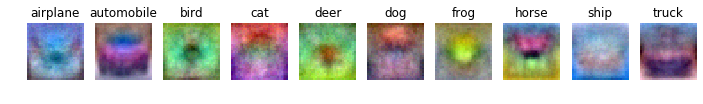

In [22]:
# Посмотрим на изображение весов модели
weights = model.get_weights()[0]  # 3072 x 10
weights = weights.T  # 10 x 3072
# Отнормируем веса в диапазон [0..255]
weights = renormalize(weights)
# 10x3072 = 10x32х32х3
weights = weights.reshape(10, 32, 32, 3)
plot_cifar_imgs(weights, np.arange(10))

Видно, что классификатор пытается уловить средние цвета и форму изображений разных классов.

## Обучения двухслойной сети
Линейный классификатор можно интерпретировать как поверхность, разделяющую разные классы в многомерном прострастве всех возможноых пикселей.

![linear_separation](img/linear_separation.png)

Чтобы получить поверхности более сложной формы используют несколько линейный слоев, причем к выходу каждого слоя применятся нелинейная функция - активация. Если не применять активацию, то сколько бы линейных слоев мы не сделали, все они могут быть выражены одним линейным слоем. Понятие искуственной нейронной сети применяют именно к набору линейных слоев с активациями, по аналогии с нейронами у животных.

Разные функции активации:

![activations](img/activations.png)

In [23]:
# Двухслойная нейросеть
learning_rate = 0.1
hidden_layer = 256  # размерность выходов первого слоя сети (их называют скрытыми)

model = tf.keras.Sequential([
    # Добавляем дополнительный слой [3072 -> hidden_layer] с активацией ReLU (Rectifier Linear Unit)
    tf.keras.layers.Dense(hidden_layer, input_shape=(3072, ), activation='relu'), 
    # [hidden_layer -> 10]
    tf.keras.layers.Dense(10, activation='softmax'),     
])

model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

model.fit(
    x=(cifar10_train_vectors / 255.),
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(cifar10_test_vectors / 255., tf.one_hot(cifar10_test['labels'], depth=10)),
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 57us/sample - loss: 1.9976 - categorical_accuracy: 0.2784 - val_loss: 1.8948 - val_categorical_accuracy: 0.3156
Epoch 2/5
50000/50000 [==============================] - 3s 53us/sample - loss: 1.7314 - categorical_accuracy: 0.3835 - val_loss: 1.6862 - val_categorical_accuracy: 0.4049
Epoch 3/5
50000/50000 [==============================] - 3s 54us/sample - loss: 1.6482 - categorical_accuracy: 0.4193 - val_loss: 1.6890 - val_categorical_accuracy: 0.3990
Epoch 4/5
50000/50000 [==============================] - 3s 54us/sample - loss: 1.6126 - categorical_accuracy: 0.4327 - val_loss: 1.6155 - val_categorical_accuracy: 0.4288
Epoch 5/5
50000/50000 [==============================] - 3s 54us/sample - loss: 1.5943 - categorical_accuracy: 0.4408 - val_loss: 1.6029 - val_categorical_accuracy: 0.4380


По мере роста глубины сети и размерности скрытых слоев, точность будет немного возрастать и выйдет на плато. Такие сети, где все нейроны соседних слоев связаны между собой, называют полносвязными (**Fully-connected nets**).

![fully_connected](img/fully_connected.png)

Качество предсказаний такой модели мало отличается от деревьев решений (если не меньше), поскольку все пиксели изображений рассматриваются по отдельности. Если мы перемешаем все пиксели на всех изображениях одинаковым образом, качество предсказаний не измениться.

Чтобы включить в сеть информацию о простраственной связности пикселей, используют сверточные нейросети.

## Сверточные нейросети

В основе сверточных сетей лежит идея совместного использования весовых коэффициентов. Изображение сворачивают с фильтром заданного размера, веса которого одинаковы для всех дискретных положений свертки. Вся операция характеризуется шириной, высотой и глубиной фильтров (если мы имеем дело с двумерными изображениями), а также смещением положения фильтра на каждом шаге свертки и поведением на границах изображения.

![convolution](img/convolution.gif)

В данном случае мы имеем фильтр с размерностью 3x3x1, применяемому к изображению 5х5х1 со смещением (**strides**), равным двум и добавлением пикселей-заполнителей по краям (**padding**). Также может варьируется количество самих фильтров. В зависимости от значений всех этих параметров, на выходе **сверточного слоя** сети получаются матрицы признаков (**feature maps**) разной размерности. Например, пусть изображение имеет размерность 32х32х3; тогда после применения 5 фильтров с размерами 7х7 и шагом 5, выходная матрица признаков будет иметь размерость 6х6х5:

$$Размер~выхода = \frac{N - F}{stride} + 1 = \frac{32 - 7}{5} + 1 = 6$$

Здесь нам не нужно дополнительно заполнение по краям, так как все фильтры умещаются в изображение с заданным шагом. По мере мере роста числа последовательных слоев, на каждый нейрон будет приходится все больше информации исходного изображения. 

![receptive_field](img/receptive_field.png)

Таким образом, веса нейронов кодируют базовое изображения и мы получаем сжатое представление о содержании изображения. Начальные сверточные слои захватывают информацию о текстурах на изображении (брусчатка/шерсть/кирпичи), а финальные слои - информацию о содержании изображения (улица/кошка/дом).

Часто в сверточных сетях размерности по ширине и высоте сохраняются и меняется только число фильтров (либо и оно тоже остается постоянным, а слой только увеличивает глубину сети).

Несмотря на то, что сети называют сверточными, в практических приложениях используется операция кросс-корреляции (фильтры в этом случае не перевернуты).

In [24]:
# Теперь на вход сети будут подоваться не векторы длиной 3072, а изображения
# Вычтем среднее и отнормируем их
mean, std = cifar10_train['data'].mean(), cifar10_train['data'].var()
cifar10_train_norm_img = (cifar10_train['data'] - mean) / std
cifar10_test_norm_img = (cifar10_test['data'] - mean) / std

In [25]:
# Tensorflow содержит модуль tf.nn, в котором реализованы сверточные слои tf.nn.conv2d
# tf.keras также включает необходимые классы

learning_rate = 0.005
batch_size = 128
n_epochs = 10


model = tf.keras.Sequential([
    # Задаем сверточный слой 7x7, на выходе получаем 26x26x32 нейрона
    tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), strides=(1, 1), activation='relu',
                           input_shape=(32, 32, 3)),
    # Задаем pooling слой. По умолчанию 2x2, следовательно на выходе 13x13x32
    tf.keras.layers.MaxPooling2D(),
    
    # Ограничим размер нашей сети одним сверточным слоем с пуллингом
    # Остальные 2 слоя оставим полносвязыми
    # Чтобы срастить светочные слои с полносвязными используем Flatten,
    # которые преобразует выходную матрицу сверточного слоя в вектор
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(10, activation='softmax'),     
])

model.compile(
    # Воспользуемся более продвинутым оптимизатором
    # Adam (adaptive moment estimation) - это разновидность SGD,
    # включающая момент (инерция изменения градиента)
    # и подстройку значения градиента под отдельные параметры
    # [*] Kingma and Ba, “Adam: A method for stochastic optimization”, ICLR 2015
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

model.fit(
    x=cifar10_train_norm_img,
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(cifar10_test_norm_img, tf.one_hot(cifar10_test['labels'], depth=10)),
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 111us/sample - loss: 1.4420 - categorical_accuracy: 0.4831 - val_loss: 1.2404 - val_categorical_accuracy: 0.5623
Epoch 2/10
50000/50000 [==============================] - 4s 86us/sample - loss: 1.0560 - categorical_accuracy: 0.6273 - val_loss: 1.0556 - val_categorical_accuracy: 0.6332
Epoch 3/10
50000/50000 [==============================] - 4s 85us/sample - loss: 0.8753 - categorical_accuracy: 0.6929 - val_loss: 0.9954 - val_categorical_accuracy: 0.6547
Epoch 4/10
50000/50000 [==============================] - 4s 86us/sample - loss: 0.7775 - categorical_accuracy: 0.7299 - val_loss: 0.9812 - val_categorical_accuracy: 0.6593
Epoch 5/10
50000/50000 [==============================] - 4s 86us/sample - loss: 0.7243 - categorical_accuracy: 0.7509 - val_loss: 0.9573 - val_categorical_accuracy: 0.6681
Epoch 6/10
50000/50000 [==============================] - 4s 85us/sample - loss: 0.6

Размерность весов первого слоя: (7, 7, 3, 32)


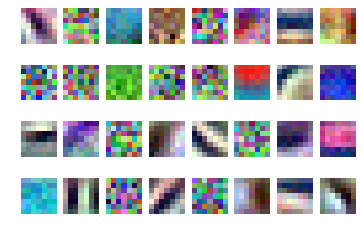

In [26]:
# Постоим веса
weights = model.get_weights()[0]
print('Размерность весов первого слоя:', weights.shape)

weights = weights.transpose(3, 0, 1, 2)
weights = renormalize(weights)

fig, axes = plt.subplots(4, 8, figsize=(6, 4))
axes = axes.ravel()
for ax, w in zip(axes, weights):
    ax.imshow(w.astype('uint8'), cmap='plasma')
    ax.axis('off')


Сеть даже с одним сверточным слоем достаточно быстро набирает хорошую точность на тренировочный выборке, по сравнению с полносвязной сетью. Однако разница в точности предсказаний на тренеровочных и тестовых данных возросла. Поэтому необходима дополнительная регуляризация.

Самым действенным способом регуляризации сети является увеличение размера тренировочной выборки.

Может использоваться классическая l1, l2 регуляризация, т.е. ограничение на значение весов сети. Другой способ регуляризации - **dropout**, когда часть нейронов сети не учавствуют в обучении:

![dropout](img/dropout.png)

Сеть учиться получать одинаковый результат разными способами, не переобучая конкретные нейроны.

[*] Srivastava et al, “Dropout: A simple way to prevent neural networks from overfitting”, JMLR 2014

В некоторых задачах, связанных с картинками, также можно искусственно увеличить размер выборки, применяя различные преобразования - вращения, приближения, отражения - к исходным изображениям.

In [27]:
# Обучим ту же сеть, но добавив дропаут и регуляризацию весов

learning_rate = 0.005
batch_size = 128
n_epochs = 10


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), strides=(1, 1), activation='relu',
                           input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    # L2 регуляризация весов задается для каждого слоя по отдельности
    # необходимо задать коэффиицент при норме весов
    tf.keras.layers.Dense(256, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.05),  # доля отключаемых нейронов
    tf.keras.layers.Dense(10, activation='softmax'),     
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

model.fit(
    x=cifar10_train_norm_img,
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(cifar10_test_norm_img, tf.one_hot(cifar10_test['labels'], depth=10)),
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 97us/sample - loss: 1.6033 - categorical_accuracy: 0.4629 - val_loss: 1.4422 - val_categorical_accuracy: 0.5320
Epoch 2/10
50000/50000 [==============================] - 4s 88us/sample - loss: 1.3332 - categorical_accuracy: 0.5735 - val_loss: 1.2739 - val_categorical_accuracy: 0.5942
Epoch 3/10
50000/50000 [==============================] - 4s 88us/sample - loss: 1.1730 - categorical_accuracy: 0.6317 - val_loss: 1.1801 - val_categorical_accuracy: 0.6300
Epoch 4/10
50000/50000 [==============================] - 4s 88us/sample - loss: 1.0614 - categorical_accuracy: 0.6719 - val_loss: 1.1334 - val_categorical_accuracy: 0.6479
Epoch 5/10
50000/50000 [==============================] - 4s 88us/sample - loss: 0.9949 - categorical_accuracy: 0.6976 - val_loss: 1.1061 - val_categorical_accuracy: 0.6529
Epoch 6/10
50000/50000 [==============================] - 4s 88us/sample - loss: 0.95

Размерность весов первого слоя: (7, 7, 3, 32)


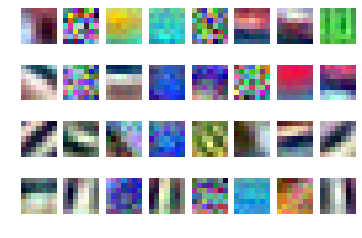

In [28]:
# Постоим веса
weights = model.get_weights()[0]
print('Размерность весов первого слоя:', weights.shape)

weights = weights.transpose(3, 0, 1, 2)
weights = renormalize(weights)

fig, axes = plt.subplots(4, 8, figsize=(6, 4))
axes = axes.ravel()
for ax, w in zip(axes, weights):
    ax.imshow(w.astype('uint8'), cmap='plasma')
    ax.axis('off')


Регуляризация практические всегда приводит к ухудшению результата на тренировочной выборки и не всегда - к улучшению на тестовой выборке.

## Задачи, решаемые сверточными нейросетями
- Классификация изображений
- Сегментация (instance и semantic segmentation)
- Подсчет объектов

### Архитектуры сетей, используемые в задачах классификации
Мы рассмотрели общие принципы построения и обучения сверточных нейросетей и применили их для классификации изображений набора данных CIFAR10. Задача классикации является достаточно хорошо изученной и в последние годы появилось множество подходов к ее решению. В основном подходы основываются на различных архитектурах сверточных сетей, которые характеризуются временем обучения/предсказания, количеством параметров (следовательно и необходимыми вычислительными мощностями) и качеством предсказаний.

- ***AlexNet*** - первая сверточная нейросеть, победившая в соревновании по классификации ImageNet. В ней используется активация ReLU, в отличие от прежних нейросетей, где применялись sigmoid или tanh. Последние две функции активации сильно ослабляют распросранение градентов, когда выход функции близок к 0 и 1 (для signomoid) или -1 и 1 (для tanh).
![alexnet](img/alexnet.png)
- ***VGG*** - сеть, которая усовершенствовала AlexNet, заменив "тяжелые" начальные свертки 11х11 и 5х5 на свертки 3х3. Также увеличилась глубина сети.
- ***Inception-v1 (-v2 и -v3)*** сети направлены на дальнейшую оптимизацию архитектуры сети. Они состоят из специальных блоков, в которых параллельно осуществляются свертки 3x3 (разложенные в 1х3 и 3х1), 1x1 (для увеличения числа фильтров) и другие. Это позволило существенно снизить количество параметров сети при сохранении точности.
- ***ResNet*** - сеть, в которой решается проблема распространения градиента в глубину при обучении. В ней используются residual блоки, в которых помимо свертки есть прямая связь между входом и выходом.
![resnet_block](img/residual_block.png)

Таким образом градиент с последних слоев может распространяться к первым слоям напрямую.

| Название      | Число слоев | Кол-во параметров | Top-5 точность | Год
| ------------- | :---------- |:-----------------:| --------------:| -----:|
| AlexNet       | 8           | 61 млн.           | 80.2           |  2012
| VGG           | 19          | 138 млн.          | 91.2           | 2013
| Inception-v1  | ?           | 7 млн.            | 89.3           | 2013
| Inception-v3  | 159         | 23.8 млн.         | 95.7           | 2015
| ResNet-50     | 50          | 25.5 млн.         | 93             | 2015
| ResNet-152    | 152         | 60.2 млн.         | 96.4           | 2015

**[AlexNet]** Krizhevsky et al, ImageNet Classification with Deep Convolutional Neural Networks, 2012

**[VGG]** Simonyan, Zisserman, Very Deep Convolutional Networks For Large-Scale Image Recognition, 2015

**[Inception-v3]** Szegedy et al, Rethinking the Inception Architecture for Computer Vision, 2015

**[ResNet]** He et al, Deep Residual Learning for Image Recognition, 2015

In [29]:
# Некоторые реализованные архитектуры можно найти в tf.keras
resnet = tf.keras.applications.ResNet50(
    # не использовать финальный полносвязный слой
    include_top=False,  
    # указав weights='imagenet', 
    # веса будут инициализированны весами resnet50,
    # предобученной на Imagenet
    weights=None,  
    input_shape=(32, 32, 3)
)
# Берем выходной слой resnet50 для наших входов [1, 1, 2048] 
x = resnet.output
# Преобразуем в вектор
# Создаем класс Flatten и вызываем его с аргументом предыдущего слоя
# Это функциональный стиль построения моделей в tf.keras 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Слой предсказаний
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

# Теперь необходимо обернуть модель в класс Model
# (ранее мы использовали для этого класс Sequential())
model = tf.keras.Model(inputs=resnet.input, outputs=predictions)

C:\Anaconda3\envs\dl_env\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [30]:
n_epochs = 30
batch_size = 32

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 28:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

cifar10_train_preproc = cifar10_train['data'] / 255
cifar10_test_preproc = cifar10_test['data'] / 255
train_mean = cifar10_train_preproc.mean()

cifar10_train_preproc -= train_mean
cifar10_test_preproc -= train_mean

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule(0)),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

model.fit(
    x=cifar10_train_preproc,
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(cifar10_test_preproc, tf.one_hot(cifar10_test['labels'], depth=10)),
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Learning rate:  0.001
Train on 50000 samples, validate on 10000 samples
Learning rate:  0.001
Epoch 1/30
50000/50000 [==============================] - 143s 3ms/sample - loss: 1.7667 - categorical_accuracy: 0.3723 - val_loss: 1.4689 - val_categorical_accuracy: 0.4738
Learning rate:  0.001
Epoch 2/30
50000/50000 [==============================] - 135s 3ms/sample - loss: 1.4766 - categorical_accuracy: 0.4723 - val_loss: 1.5721 - val_categorical_accuracy: 0.4490
Learning rate:  0.001
Epoch 3/30
50000/50000 [==============================] - 135s 3ms/sample - loss: 1.2577 - categorical_accuracy: 0.5543 - val_loss: 1.3234 - val_categorical_accuracy: 0.5438
Learning rate:  0.001
Epoch 4/30
50000/50000 [==============================] - 134s 3ms/sample - loss: 1.0714 - categorical_accuracy: 0.6289 - val_loss: 1.0517 - val_categorical_accuracy: 0.6508
Learning rate:  0.001
Epoch 5/30
50000/50000 [==============================] - 135s 3ms/sample - loss: 0.9515 - categorical_accuracy: 0.6723 - 

Размерность весов первого слоя: (7, 7, 3, 64)


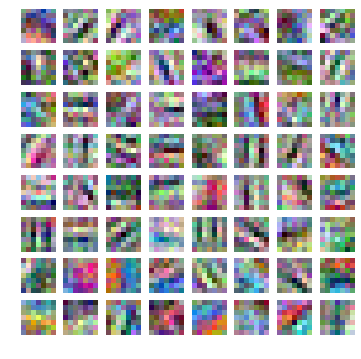

In [31]:
# Постоим веса
weights = model.get_weights()[0]
print('Размерность весов первого слоя:', weights.shape)

weights = weights.transpose(3, 0, 1, 2)
weights = renormalize(weights)

fig, axes = plt.subplots(8, 8, figsize=(6, 6))
axes = axes.ravel()
for ax, w in zip(axes, weights):
    ax.imshow(w.astype('uint8'), cmap='plasma')
    ax.axis('off')


### Сегментация объектов на изображении
В задаче сегментации для каждого пикселя на изображении надо указать, принадлежит он к определенному классу объектов или нет. Различают 2 вида сегментации: semantic segmentation и instance segmentation. В первом случае должны быть отмечены все пиксели принадлежащие классу, т.е. если на картинке есть стулья они все должны быть отмечены. При instance сегментации необходимо также указать, если пиксели принадлежат разным объектам.

![segmentation](img/segmentation.png)

В задаче обычно дается 2 картинки - оригинальные изображения и маски, указывающие, какие пиксели принадлежат искомому классу. Трудозатраты на разметку для сегментации существенно выше, чем для классификации, поэтому такие наборы данных меньше. В связи с этим большой положительный эффект на качество сети имеют аугментации, т.е. создание искусственных данных на основе имеющихся (вращение, растягивания, отражения имеющихся изображений).

Один из эффективных методов для решения задачи сегментации является сеть с архитектурой ***U-net***. Основная идея заключается в последовательном сжатии исходных изображений, декодировании, а также объединение декодированных слоев с оригинальными слоями того же размера. Таким образом, сети будут доступны как высокоинформативные сжатые признаки, так и особенности изначальных изображений. В U-net используется upsampling-convolution, где размер слоя после свертки становиться больше, чем до нее.

![unet](img/unet.png)

**[U-net]** Ronnenberger et al, U-net - Convolutional Networks for Biomedical Image Segmentation, 2015

В качестве примера задачи приведем соревнование *2018 Data Science Bowl* на платформе Kaggle, где нужно было отмечать ядра клеток на медицинских снимках.

https://www.kaggle.com/c/data-science-bowl-2018/overview

В решении победителей https://www.kaggle.com/c/data-science-bowl-2018/discussion/54741#latest-477226, используется U-net. Главная особенность решения - предсказывались не только размеченные маски ядер, но и граница между ними. Таким образом, из задачи semantic segmentation делалась instance segmentation. Дополнительная задача для нейросети - определение границ - помогает лучше разделять близко расположенные ядра и улучшить финальный результат.

![ds_bowl2018](img/ds_bowl2018.png)

### Подсчет объектов на примере соревнования *Kaggle Sea Lion Population*

https://www.kaggle.com/c/noaa-fisheries-steller-sea-lion-population-count

В этой задаче нужно было предсказать количество морских котиков на снимках с квадракоптеров. Снимки большие, ~5500x3500. Котики разделены на 5 групп (взрослые самцы, молодые самцы, взрослые самки, подростки и детеныши). Тренировочные данные (1000 изображений) представляли из себя пару: оригинальная картинка и картинка, где котики отмечены точками (считать нужно было самостоятельно). Тестовые данные - 18000 изображений без точек. Метрика - RMSE, усредненная по классам.

![sea_lions](img/sea_lions.png)

Во многих решениях картинки разбивались на более мелкие изображения (например, 256х256), чтобы уменьшить количество необходимых вычислений.

Решения:
- 2 место: 2 этапа - использование U-net для предсказания квадратов на месте котиков:
![sea_lion_second](img/sea_lion_second.png)
Далее из картинок с квадратиками извлекались вторичные признаки: сумма предсказанных вероятностей, сумма вероятностей выше заданного порога, число и сумма скоплений квадратов. Все эти признаки подавались на вход моделям, реализующим алгоритмы градиентного бустинга для получения итогового количества котиков.
- 1 место: предобученная на Imagenet сверточная сеть VGG тренировалась для непосредственного предсказания количества котиков (регрессия). Кроме того, финалные предсказания модели были некоторым образом изменены. Например, количество котиков-подростков было умножено на 1.5, количество детенышей - на 1.2. Эти числа выбирались исходя из качества предсказаний на открытой части тестовой выборки (места распределяются по предсказаниям на закрытой части выборки). Предполагается, что это связано с различием между тренировочными и тестовыми данными.

Ссылки на решения:

https://www.youtube.com/watch?v=PZfD-StZltk - 2 место

https://habr.com/ru/company/ods/blog/337548/ - 4 место